In [ ]:
from google.colab import drive
from tensorflow import keras

In [ ]:
drive.mount._DEBUG = True
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/'

In [ ]:
file = ''.join(root_path+'Image.zip')
file

'gdrive/My Drive/Image.zip'

In [ ]:
!mkdir datas
import zipfile
with zipfile.ZipFile(file,"r") as zip_ref:
    zip_ref.extractall("datas")

In [ ]:
!rm '/content/datas/Image/DogHead/dog000590a.jpg'

In [ ]:
#!find . -name 'dog000590a.jpg'

In [ ]:
path = '/content/datas/Image'
import os
from skimage.io import imread
for subdir in os.listdir(path):
    print(subdir)
    current_path = os.path.join(path, subdir)
    nb = 0
    for file in os.listdir(current_path):
        if (file[-3:] in {'bmp', 'gif'}):
            print(os.path.join(current_path, file))
            os.remove(os.path.join(current_path, file))

In [ ]:
import tensorflow as tf

print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.4.1


## Create Dataset

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = 150

In [ ]:
train_ds = image_dataset_from_directory(directory='./datas/Image', 
                                        validation_split=0.2,
                                        subset='training',
                                        labels='inferred', 
                                        label_mode='categorical',
                                        seed=123,
                                        image_size=(IMG_SIZE, IMG_SIZE),
                                        batch_size=BATCH_SIZE)

Found 2415 files belonging to 21 classes.
Using 1932 files for training.


In [ ]:
validation_ds = image_dataset_from_directory(directory='./datas/Image', 
                                        validation_split=0.2,
                                        subset='validation',
                                        labels='inferred', 
                                        label_mode='categorical',
                                        seed=123,
                                        image_size=(IMG_SIZE, IMG_SIZE),
                                        batch_size=BATCH_SIZE)



Found 2415 files belonging to 21 classes.
Using 483 files for validation.


In [ ]:
class_names=[i[:-4] for i in train_ds.class_names]
print(class_names)

['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle', 'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Nat', 'Panda', 'Pig', 'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf']


## Preview images

In [ ]:
import matplotlib.pyplot as plt


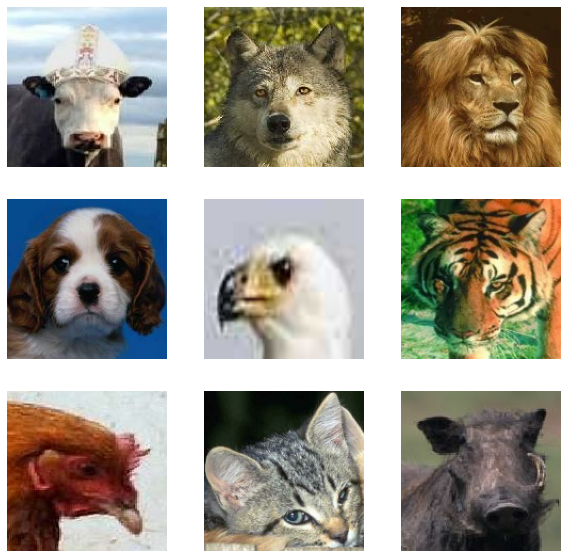

In [ ]:
plt.figure(figsize=[10,10])
for image_batch, label_batch in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")



In [ ]:
image_batch.shape

TensorShape([64, 150, 150, 3])

## Data Augmentation

Implementing data augmentation using keras.experimental.preprocessing.

Preprocessing the data and applying augmentation inside the model. This will apply preprocessing synchronously with the model execution, and on GPU. Also saves from implementing server-side logic for preprocessing.


In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ], name="data_augmentation")

### Preview Augmentation

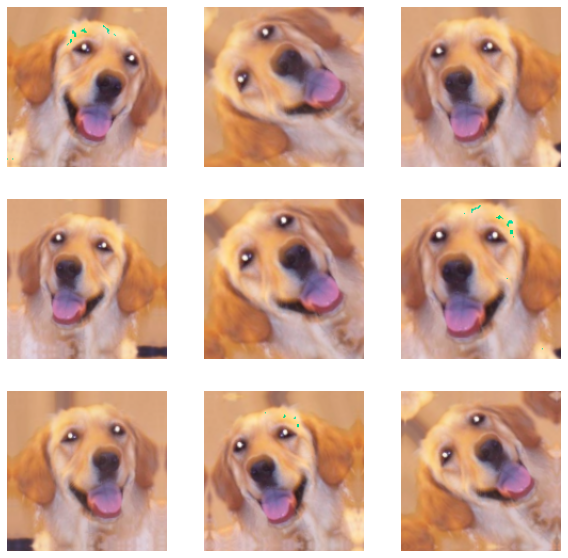

In [ ]:
plt.figure(figsize=[10,10])
for image_batch, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(image_batch)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[5].numpy().astype('uint8'))
        plt.axis("off")

 **With Xception model pretrained**

In [ ]:
import numpy as np
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(len(class_names),activation='softmax')(x)
model1 = keras.Model(inputs, outputs)

model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 21)                43029 

**With Grid Search**

In [ ]:
#Grid search
#Range of Values - The Grid
# Define the range of values

# Model Design Components
#activation =  ['relu', 'elu'] # You can also try 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'
#kernel_initializer = ['uniform', 'normal'] # You can also try lecun_uniform', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'
#optimizer = ['Adam', 'Nadam','SGD'] # You can also try 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adamax'
optimizer = ['Adam']
# Hyperparameters
epochs = [5,10] # You can also try 20, 30, 40, etc...
batch_size = [8,16] # You can also try 2, 4, 8, 16, 32, 64, 128 etc...
dropout_rate = [0.4,0.5] # No dropout, but you can also try 0.1, 0.2 etc...

In [ ]:
def create_model(dropout_rate=0.2,
                 optimizer='Adam'):
    
    base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    )  # Do not include the ImageNet classifier at the top.

    # Freeze the basmodel_best= create_model(dropout_rate=0.5,
    base_model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)  # Apply random data augmentation

    # Pre-trained Xception weights requires that input be normalized
    # from (0, 255) to a range (-1., +1.), the normalization layer
    # does the following, outputs = (inputs - mean) / sqrt(var)
    norm_layer = keras.layers.experimental.preprocessing.Normalization()
    mean = np.array([127.5] * 3)
    var = mean ** 2
    # Scale inputs to [-1, +1]
    x = norm_layer(x)
    norm_layer.set_weights([mean, var])

    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    #x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    x = keras.layers.Dropout(dropout_rate)(x)
    outputs = keras.layers.Dense(len(class_names),activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    # Compile model
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             #optimizer=keras.optimizers.Adam(),
             optimizer=optimizer,
             metrics=['accuracy'])
    return model

In [ ]:
# Create the model
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=create_model)

In [ ]:
# Prepare the Grid
param_grid = dict(epochs=np.array(epochs), 
                  batch_size=batch_size, 
                  optimizer=optimizer,
                  dropout_rate=dropout_rate)

In [ ]:
inter = train_ds.as_numpy_iterator()

In [ ]:
import numpy as np
X_train=np.empty(shape=(0,150,150,3))
y_train=np.empty(shape=(0,21))
for i in train_ds.as_numpy_iterator():
  X_train = np.concatenate((X_train,i[0]),axis=0)
  y_train = np.concatenate((y_train,i[1]),axis=0)

In [ ]:
#X_train

In [ ]:
#Grid Search
# Perform the Search!
import numpy as np
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=2)
grid_result = grid.fit(X_train,y_train)

In [ ]:
#Results
# Show results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
model_best= create_model(dropout_rate=0.5,
                 optimizer='Adam')

In [ ]:
model_best

In [ ]:
batch_size = 64
epochs = 10

In [ ]:
model_best.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])
model_best.fit(train_ds, epochs=epochs, validation_data=validation_ds)

**En compilant avec un taux d'apprentissage de 1e-5, et en reentrainant Xception**

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model_best.summary()

model_best.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate (alpha) => W = W - alpha*grad 
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 20
model_best.fit(train_ds, epochs=epochs, validation_data=validation_ds)

**Prediction**

In [ ]:
img = tf.keras.preprocessing.image.load_img('gdrive/MyDrive/google/chevre2.jpeg', target_size=(IMG_SIZE, IMG_SIZE, 3))

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_best.predict(img_array)
score = tf.nn.softmax(predictions[0])
#print(predictions)
print(score)
class_names[np.argmax(predictions)]

tf.Tensor(
[0.04459741 0.04459905 0.04459748 0.05526746 0.04461278 0.04484693
 0.04460073 0.04459894 0.04459767 0.04459758 0.04459748 0.04459753
 0.04459761 0.04459802 0.0445974  0.04459979 0.04460084 0.04469239
 0.09700786 0.0445974  0.04459761], shape=(21,), dtype=float32)


'Sheep'

In [ ]:
print(f"The prediction is '{class_names[np.argmax(predictions)]}' with a score of {np.max(predictions)*100:.2f}%")

The prediction is 'Sheep' with a score of 77.71%


**Enregistrement du modele**

In [ ]:
model_best.save('Xception_model.h5')

In [ ]:
from keras.models import load_model
Xception_model = load_model('Xception_model.h5', compile=False)

In [ ]:
img = tf.keras.preprocessing.image.load_img('gdrive/MyDrive/google/chevre2.jpeg', target_size=(IMG_SIZE, IMG_SIZE, 3))

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = Xception_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
#print(predictions)
print(score)
class_names[np.argmax(predictions)]

tf.Tensor(
[0.04459741 0.04459905 0.04459748 0.05526746 0.04461278 0.04484693
 0.04460073 0.04459894 0.04459767 0.04459758 0.04459748 0.04459753
 0.04459761 0.04459802 0.0445974  0.04459979 0.04460084 0.04469239
 0.09700786 0.0445974  0.04459761], shape=(21,), dtype=float32)


'Sheep'

**With grid search on new model**

In [ ]:
def create_new_model(Conv2D_loop=10, filter=32):
    # Create new model
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)  # Apply random data augmentation
    #print(x.shape)

    norm_layer = keras.layers.experimental.preprocessing.Normalization()
    mean = np.array([127.5] * 3)
    var = mean ** 2
    # Scale inputs to [-1, +1]
    x = norm_layer(x)
    norm_layer.set_weights([mean, var])
    for i in range(Conv2D_loop):
      #print('boucle',i)
      #print(x.shape)
      x = keras.layers.Conv2D((i+1)*filter, 3, strides=2, padding="same")(x)
      #print(x.shape)
      x = keras.layers.Activation("relu")(x)

    x = keras.layers.Conv2D(64, 3, padding="same")(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.GlobalAveragePooling2D()(x)  

    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(len(class_names),activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    # Compile model
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=keras.optimizers.Adam(),
             #optimizer='Adam',
             metrics=['accuracy'])
    return model

In [ ]:
new_model= create_new_model(Conv2D_loop=10)

In [ ]:
epochs = 10
new_model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

In [ ]:
# Hyperparameters
Conv2D_loop = [5,10] 
filter = [16,32]
epochs = [20]

In [ ]:
# Create the model
from keras.wrappers.scikit_learn import KerasClassifier
model_new = KerasClassifier(build_fn=create_new_model)

In [ ]:
# Prepare the Grid
param_grid_new = dict(epochs=epochs,
                      Conv2D_loop=Conv2D_loop,
                      filter=filter)

In [ ]:
inter = train_ds.as_numpy_iterator()

In [ ]:
import numpy as np
X_train=np.empty(shape=(0,150,150,3))
y_train=np.empty(shape=(0,21))
for i in train_ds.as_numpy_iterator():
  X_train = np.concatenate((X_train,i[0]),axis=0)
  y_train = np.concatenate((y_train,i[1]),axis=0)

In [ ]:
#Grid Search
# Perform the Search!
import numpy as np
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model_new, param_grid=param_grid_new, n_jobs=1, cv=3, verbose=2)
grid_result = grid.fit(X_train,y_train)